# EDA
This notebook was used to gain an understanding of how the oil market works. I conducted an EDA on various oil companies to learn their behaviors and how they relate to WTI in general.

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

import quandl

In [7]:
xls_file = pd.ExcelFile("RBRTEd.xls")
brent = xls_file.parse("Data 1")
brent.columns= brent.iloc[1]
brent=brent.iloc[2:] # remove first two rows
brent["Date"]= brent["Date"].astype('datetime64[ns]')
brent.columns= ['date','oil_price']

In [15]:
wti = quandl.get("EIA/PET_RWTC_D")
wti.reset_index(inplace=True)
wti.columns= ['date', 'oil_price']


In [16]:
shares = ['BP.L', 'CNE.L', 'ENGI.PA', 'FP.PA', 'PMO.L', 'RDSB.L', 'REP.MC', 'SLB.PA', 'STL.OL']
all_data = pd.DataFrame()

In [17]:
for index in range(len(shares)):
    stock = pd.DataFrame()
    
    stock = pd.read_csv(shares[index] + ".csv")
    stock = stock[['Date','Close']]
    stock["Date"]= stock["Date"].astype('datetime64[ns]')
    stock.columns=["date","share_price"]

    test=pd.DataFrame(wti)
    output= stock.merge(test, on="date", how="left")

    stock["oil_price"] = output["oil_price"]
    stock['share_price']= pd.to_numeric(stock['share_price'], errors= 'coerce').dropna(0)
    stock['oil_price']= pd.to_numeric(stock['oil_price'], errors= 'coerce').dropna(0)
    stock['year']= pd.to_datetime(stock['date']).dt.year
    stock['name']= shares[index]
    stock= stock.dropna()

    from sklearn.preprocessing import MinMaxScaler
    scaler=MinMaxScaler()
    stock['share_price_scaled'] = scaler.fit_transform(stock["share_price"].to_frame())


    all_data = all_data.append(stock)
    

In [22]:
all_data.head()

date  share_price  oil_price  year  name  share_price_scaled
1 2000-01-04   279.134583      25.56  2000  BP.L            0.306272
2 2000-01-05   279.134583      24.65  2000  BP.L            0.306272
3 2000-01-06   281.944702      24.79  2000  BP.L            0.315041
4 2000-01-07   279.603088      24.79  2000  BP.L            0.307734
5 2000-01-10   271.407043      24.71  2000  BP.L            0.282159

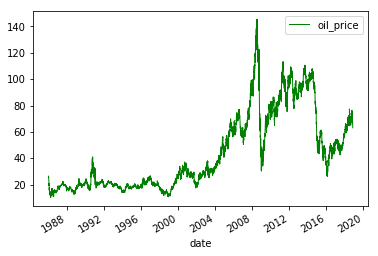

In [19]:
wti[['date', 'oil_price']].set_index('date').plot(color="green", linewidth= 1)

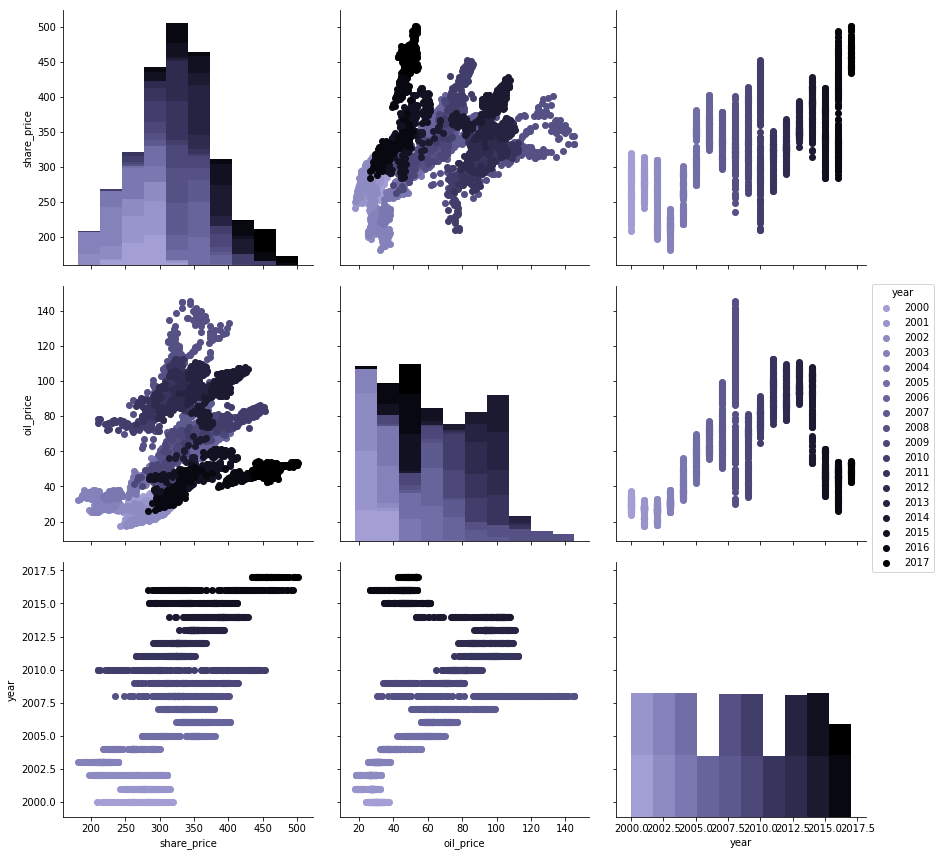

In [28]:
palette = sns.cubehelix_palette(18, start=3, rot=0, dark=0, light= 0.65, reverse = False)

sns.pairplot(all_data[all_data['name']=="BP.L"].drop(['share_price_scaled'], axis=1),
            hue= "year", palette = palette, size=4, markers = "o",
            plot_kws=dict(s=50, edgecolor="b", linewidth= 0))

# Oil companies

Previously, we see that oil company share prices are highly correlated with WTI. Now, comparing between companies we see a different story. This may be explained by different revenue segments-- with companies that have similar functions having more correlated prices than those that specialize in other functions (e.g., downstream vs upstream).

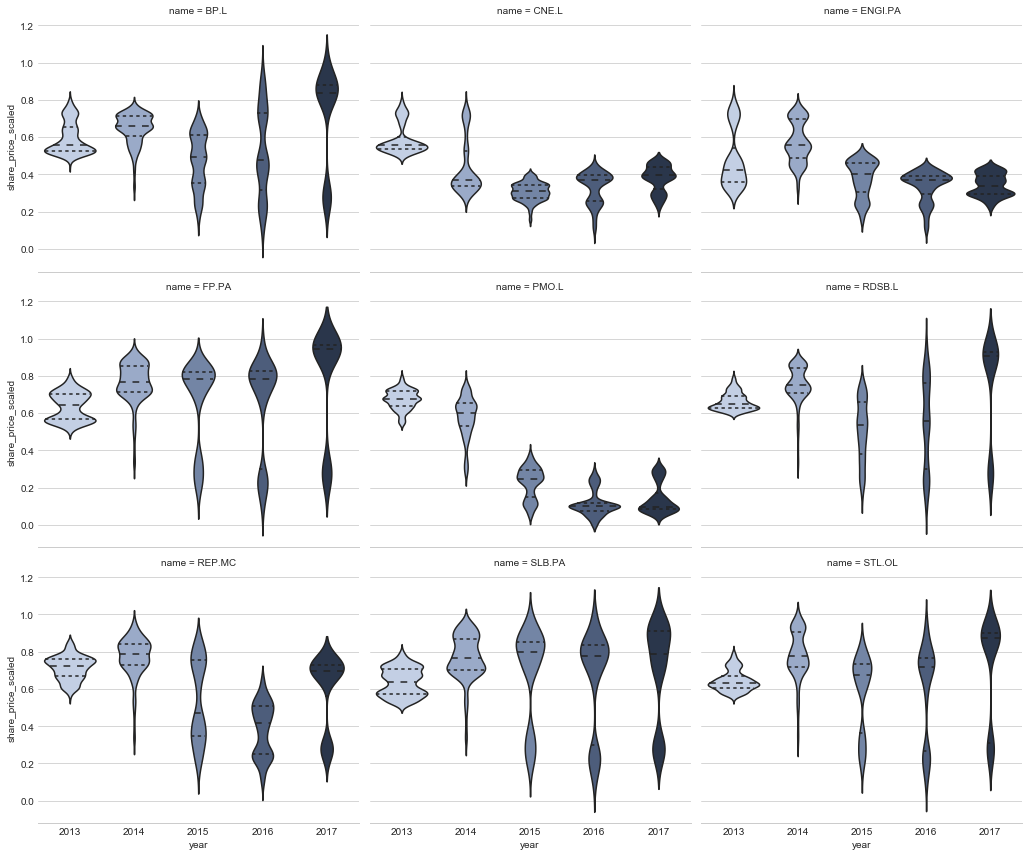

In [180]:
sns.factorplot(x="year", y="share_price_scaled", col='name', col_wrap=3, kind="violin",
              split=True, data=all_data13, inner="quart", palette= palette, trim=True, size = 4, aspect=1.2)
sns.despine(left=True)

/Users/samchow/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/samchow/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'hue'
  s)


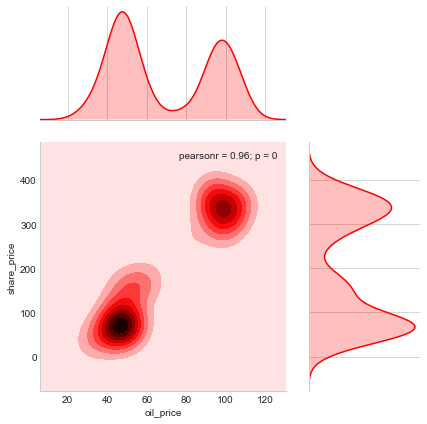

In [34]:
sns.jointplot("oil_price", "share_price", data=all_data13[all_data13['name'] == "PMO.L"], kind= "kde",
             hue= "year", size= 6, ratio=2, color="red").plot_joint(sns.kdeplot, zorder=0, n_levels= 20)

/Users/samchow/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/samchow/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'hue'
  s)


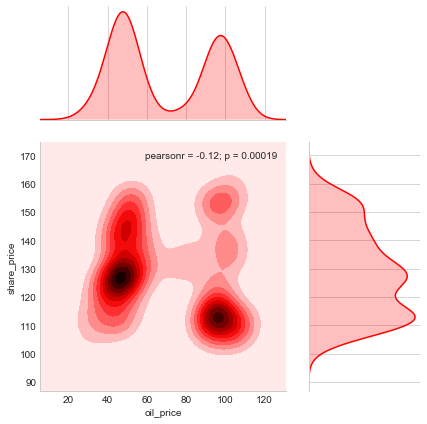

In [35]:
sns.jointplot("oil_price", "share_price", data=all_data13[all_data13['name'] == "STL.OL"], kind= "kde",
             hue= "year", size=6, ratio=2, color="red").plot_joint(sns.kdeplot, zorder= 0, n_levels=20)

# Companies vs WTI

Below, we can begin to clearly see that company stock price isn't necessarily reflective of movements in the WTI. This is interesting and a tad counter-intuitive..

/Users/samchow/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


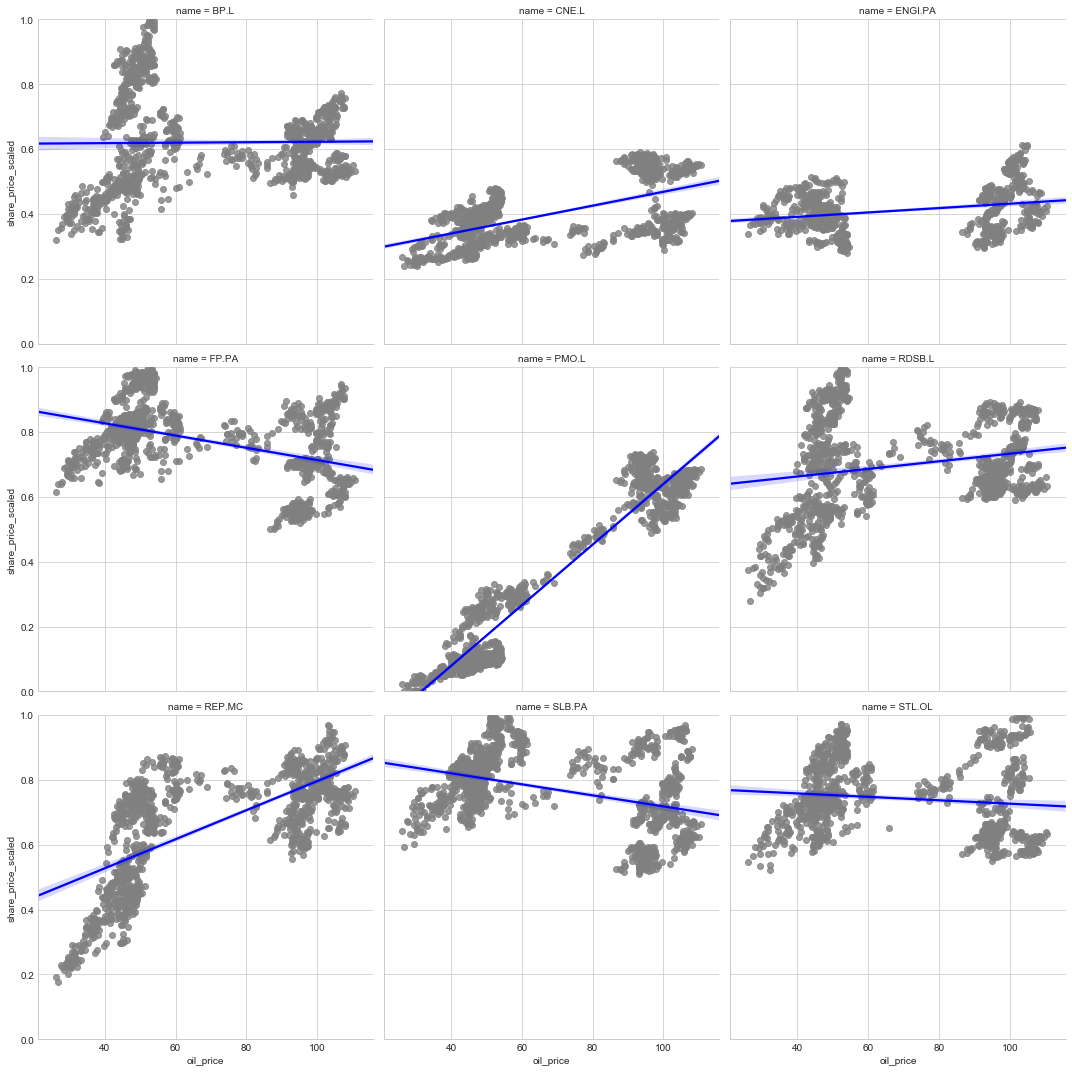

In [36]:
sns.lmplot(x="oil_price", y="share_price_scaled", col="name", ci=95, col_wrap=3,
          data=all_data13, order=1, line_kws={'color':'blue'}, scatter_kws= {'color': 'grey'}).set(
ylim=(0,1))

# Segmentation
Segmenting the above analyses by year reveals a more intuitive finding. Share prices are more correlated with WTI like previously believed. However, it is interesting that some years there isn't as strong as a relationship. Perhaps M&A activities lead to new revenue segments/customers that explain how some companies went from a negative to a positive correlation? Or perhaps a linear fit doesn't make sense given that the SP/WTI trend groups up.

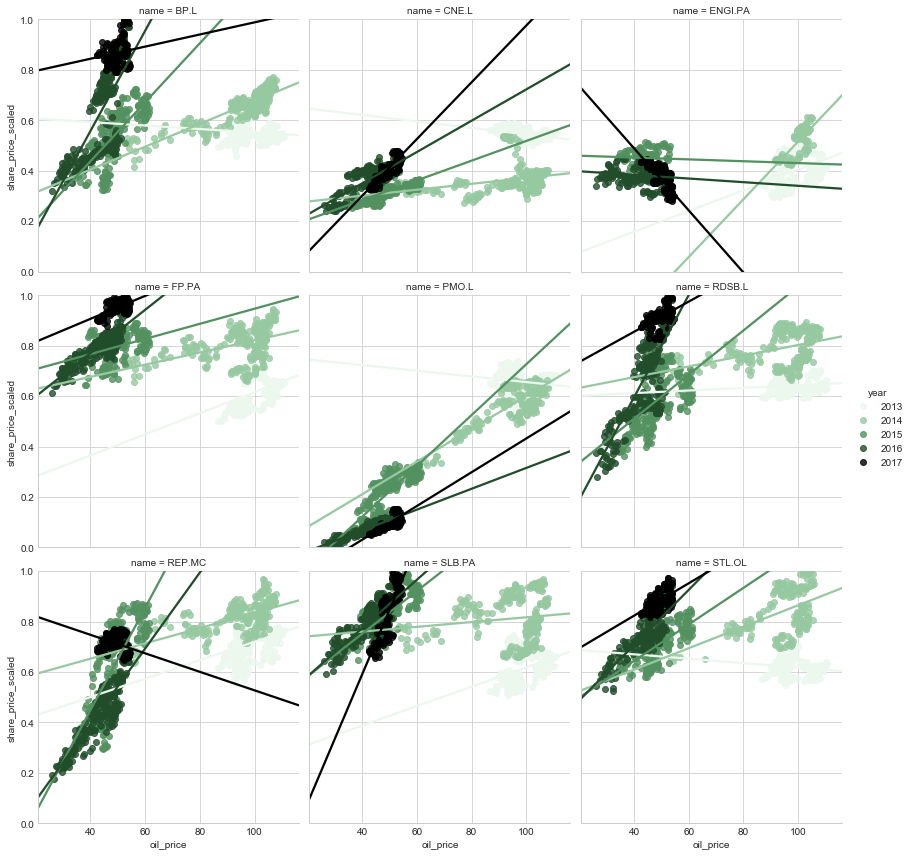

In [37]:
palette= sns.cubehelix_palette(5,start=2, rot=0, dark=0, light=.95, reverse=False)

sns.lmplot(x='oil_price', y= 'share_price_scaled', hue="year", col="name", ci=None,
          col_wrap=3, data=all_data13, order= 1, palette= palette, size= 4).set(ylim=(0,1))

# Machine Learning

This section is just exploratory and to help with thinking about other features that could possibly be used to make a better prediction of WTI. 

/Users/samchow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/samchow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


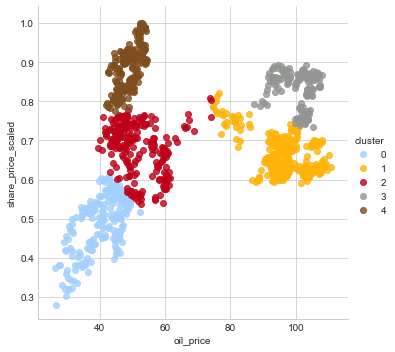

In [44]:
from sklearn.cluster import KMeans

shell=pd.DataFrame()
shell= all_data13[all_data13['name']=="RDSB.L"]

shell["oil_price_scaled"]= scaler.fit_transform(shell["oil_price"].to_frame())
shell["cluster"] = KMeans(n_clusters=5, random_state=1).fit_predict(shell[["share_price_scaled","oil_price_scaled"]])

colors = ["baby blue", "amber", "scarlet","grey","milk chocolate", "windows blue"]
palette = sns.xkcd_palette(colors)

sns.lmplot(x="oil_price", y="share_price_scaled", ci=None, palette=palette, hue="cluster", fit_reg=0, data= shell)

In [41]:
shell.year.unique()

array([2013, 2014, 2015, 2016, 2017])

# Linear Regression
Exploring Shell vs WTI

In [49]:
from sklearn import linear_model

#data preparation
shell15= pd.DataFrame()
shell15= all_data13[(all_data13['name']=="RDSB.L") & (all_data13['year']>2015)]
shell15= shell15[["share_price", "oil_price"]].reset_index()

#train and test set
train= shell15[:-100]
test= shell15[-100:]

x_train= train["oil_price"].to_frame()
y_train= train['share_price'].to_frame()
x_test = test["oil_price"].to_frame()
y_test= test['share_price'].to_frame()

#create linear regression
regr= linear_model.LinearRegression()

#Train model
regr.fit(x_train, y_train)

#Save coefficients
print("Coefficients: ", float(regr.coef_))
print("Mean Squared Error: %.2f"
     % np.mean((regr.predict(x_train)- y_train)**2))





Coefficients:  35.1578066120749
Mean Squared Error: 25341.19


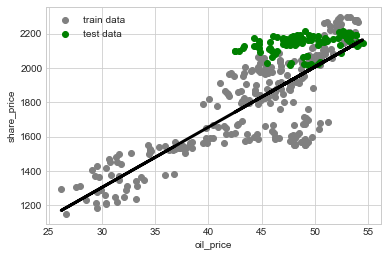

In [46]:
plt_train= plt.scatter(x_train,y_train, color='grey')
plt_test=plt.scatter(x_test, y_test, color= 'green')
plt.plot(x_train, regr.predict(x_train), color='black', linewidth=3)
plt.plot(x_test, regr.predict(x_test), color='black', linewidth=3)
plt.xlabel("oil_price")
plt.ylabel("share_price")
plt.legend((plt_train, plt_test), ("train data", "test data"))
plt.show()

# Random Forest
Trying another method with additional features. I'm most interested in understanding whether certain companies are better at predicting WTI prices. Turns out FP.PA (Total) is. Given more time, maybe a time lagged model where each company is entered in as t-1?

In [65]:
from sklearn.ensemble import RandomForestRegressor
# 1.- Data Preparation
shell15=pd.DataFrame()
shell15=all_data13[(all_data13['name']=="RDSB.L") & (all_data13['year']>2015 )]
shell15=shell15[["share_price","oil_price"]].reset_index()

# Load share price of other variables
shell15['PMO.L']=all_data13[(all_data13['name']=="PMO.L")][-373:].reset_index()['share_price']
shell15['CNE.L']=all_data13[(all_data13['name']=="CNE.L")][-373:].reset_index()['share_price']
shell15['FP.PA']=all_data13[(all_data13['name']=="FP.PA")][-373:].reset_index()['share_price']
shell15['ENGI.PA']=all_data13[(all_data13['name']=="ENGI.PA")][-373:].reset_index()['share_price']

train = shell15[:-100]
test = shell15[-100:]

x_train=train[["oil_price","PMO.L","CNE.L","FP.PA","ENGI.PA"]]
y_train=train['share_price']

x_train= x_train.dropna()
y_train= y_train.dropna()


x_test=test[["oil_price","PMO.L","CNE.L","FP.PA","ENGI.PA"]].dropna() 
y_test=test['share_price'].to_frame()


# 2.- Create Randomforest object usinig a max depth=5
regressor = RandomForestRegressor(n_estimators=200, max_depth=5 )


# 3.- Train data
clf=regressor.fit(x_train, y_train)


# 4.- Predict
y_pred=regressor.predict(x_test)
y_pred=pd.DataFrame(y_pred)


In [72]:
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regressor.predict(x_train) - y_train) ** 2))

Mean squared error: 2276.68


Feature ranking:
Feature oil_price (0.211392)
Feature PMO.L (0.016743)
Feature CNE.L (0.119423)
Feature FP.PA (0.569942)
Feature ENGI.PA (0.082499)


Text(0, 0.5, 'Importance')

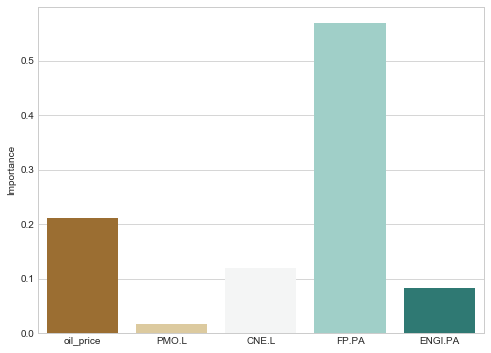

In [73]:
importances=regressor.feature_importances_

indices=list(x_train)
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("Feature %s (%f)" % (indices[f], importances[f]))

f, (ax1) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
sns.barplot(indices, importances, palette="BrBG", ax=ax1)
ax1.set_ylabel("Importance")